In [ ]:
# Install the necessary components
!pip install pyyaml==5.1 --quiet  # Installation of pyyaml 5.1

import torch  # Importing PyTorch library

# Retrieve the version of PyTorch and CUDA
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)  # Displaying versions

# Install Detectron2 from GitHub repository
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet  # Installing Detectron2

# exit(0)  # Restart runtime if needed


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.6 ; cuda:  cu124
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.9 MB/s eta 0:00:00


IMPORTING NECESSARY LIBRARIES

In [ ]:
# Basic setup
from detectron2.utils.logger import setup_logger  # Setup detectron2 logger
setup_logger()

# Import common libraries
import numpy as np
import pandas as pd
import os, random, glob
import io
import time
import datetime
import logging
import json
import torch
import cv2

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow

# Import additional libraries
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import albumentations as A
from pycocotools import mask as maskUtils

# Import detectron2 utilities
import detectron2.utils.comm as comm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import Boxes, pairwise_iou

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Downloading and Extracting the Dataset from Roboflow

In [ ]:
# Download the dataset and unzip it
!curl -L "https://app.roboflow.com/ds/yjGLZlonKb?key=1qQLR6j7yT" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip  # Download and extract dataset


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   902  100   902    0     0   2552      0 --:--:-- --:--:-- --:--:--  2555
100 17.1M  100 17.1M    0     0  14.3M      0  0:00:01  0:00:01 --:--:-- 51.8M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/07-is-250-came-to-my-car-saw-a-big-crack-in-the-rear-v0-epzwgdws1iaa1_webp.rf.f8fa8c1e25c320516c8be752fc2c6fbe.jpg  
 extracting: test/073_jpg.rf.9fb7792655a0d1aeb80a19d88d2216c2.jpg  
 extracting: test/077_jpg.rf.27e0ff0931694f718ff9ce851b1a7ae9.jpg  
 extracting: test/1150_jpg.rf.e2a4e07bcca74f8c0a698a4181be1d18.jpg  
 extracting: test/116260-IMG_9532_JPG_jpg.rf.ca2bf7ea5490c16f6a5284e5640de9e3.jpg  
 extracting: test/20240608_211701_jpg.rf.da44c321c5b85e16abc4728ea4b0a7d6.jpg  
 extracting: test/272_6_jpg.rf.ef48bd636a977979813113759191e08

Reading Categories

In [ ]:
def check_category_names(path):
# Load the annotations file
  with open(path) as f:
      annotations = json.load(f)

  # Extract the categories
  categories = annotations['categories']

  # Display the category ids and names
  for category in categories:
      print(f"Category ID: {category['id']}, Name: {category['name']}")

check_category_names("/content/test/_annotations.coco.json")

Category ID: 0, Name: car-paint-damage-dent
Category ID: 1, Name: Crack
Category ID: 2, Name: Dent
Category ID: 3, Name: PDR-Dent
Category ID: 4, Name: Paint-Crack
Category ID: 5, Name: Paint-fading
Category ID: 6, Name: Rust
Category ID: 7, Name: Scratch


In [ ]:

folders = ["/content/test", "/content/train", "/content/valid"]

file_name = "_annotations.coco.json"

def update_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    data['categories'] = [category for category in data['categories'] if category['id'] != 0]

    data['annotations'] = [annotation for annotation in data['annotations'] if annotation['category_id'] != 0]

    data['categories'].sort(key=lambda x: x['id'])

    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

for folder in folders:
    file_path = os.path.join(folder, file_name)
    update_json_file(file_path)
    print(f"Updated file: {file_path}")

print("All files updated.")

Updated file: /content/test/_annotations.coco.json
Updated file: /content/train/_annotations.coco.json
Updated file: /content/valid/_annotations.coco.json
All files updated.


In [ ]:
check_category_names("/content/test/_annotations.coco.json")


Category ID: 1, Name: Crack
Category ID: 2, Name: Dent
Category ID: 3, Name: PDR-Dent
Category ID: 4, Name: Paint-Crack
Category ID: 5, Name: Paint-fading
Category ID: 6, Name: Rust
Category ID: 7, Name: Scratch


Registering this data as a COCO instance for use in Detectron2.

In [ ]:
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")  # Register training dataset
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")  # Register testing dataset
register_coco_instances("my_dataset_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid")  # Register validation dataset

[05/27 13:09:50 d2.data.datasets.coco]: Loaded 342 images in COCO format from /content/train/_annotations.coco.json


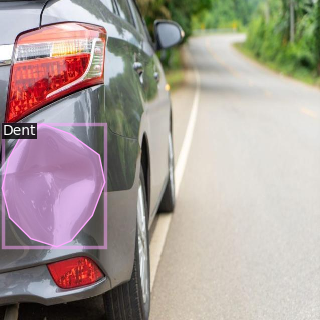

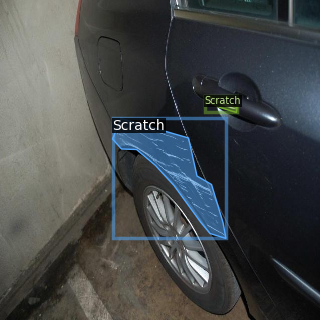

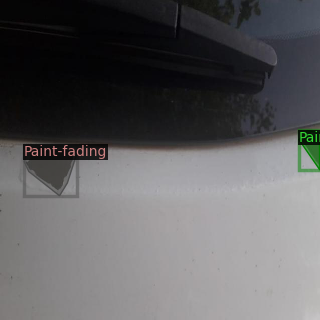

In [ ]:

# Visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

# Display random samples from the training dataset
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])  # Show visualized image